# New Section

In [ ]:
!pip install pafy youtube-dl moviepy
!pip install imageio
!pip install imageio-ffmpeg
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import ast
import re
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, TimeDistributed
from keras.applications.vgg16 import VGG16
from keras import regularizers
from sklearn.svm import SVC
import pickle
import gc


In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# root_dir = '/content/drive/MyDrive/HAR FINAL PROJECT/'
root_dir = '/content/drive/MyDrive/'
os.chdir(root_dir)
contents = os.listdir(root_dir)
for item in contents:
  pass


# PATH IF '/content/drive/MyDrive/HAR DATA/' THEN BELOW
folder_path = '25mai0020'
contents = os.listdir(folder_path)
for item in contents:
    print(item ,end = ",")

dataset,kfold1.ipynb,each_fold (1).ipynb,FLIP (1).ipynb,35runfirst.ipynb,

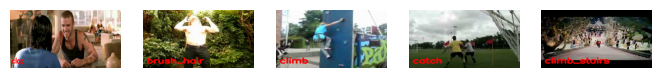

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (10, 8))

# all_classes_names = ['brush_hair','catch','chew','climb','climb_stairs','dive','draw_sword','dribble','drink','eat','fall_floor','fencing','flic_flac','golf','handstand','hit','hug','jump','kick','kick_ball','kiss','laugh','pick','pullup','punch','push','pushup','ride_bike','ride_horse','shake_hands','shoot_bow','shoot_gun','sit','situp','smile','smoke','stand','swing_baseball','sword','sword_exercise','talk','throw','turn','wave','cartwheel','pour','run','shoot_ball','somersault','clap', 'walk']

all_classes_names = ['brush_hair','catch','clap','climb','climb_stairs']
# random_range = random.sample(range(len(all_classes_names[0:15])), 15)
random_range = random.sample(range(len(all_classes_names)),5)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]


    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'25mai0020/dataset/{selected_class_Name}')


    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'25mai0020/dataset/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 220), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

    # Display the frame.
    plt.subplot(9, 6, counter)
    plt.imshow(rgb_frame, aspect= 'auto')
    plt.axis('off')

    plt.savefig('output_image.png')

In [ ]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30
DATASET_DIR = "25mai0020/dataset"
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = all_classes_names

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    # list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

In [ ]:
current_path = os.getcwd()
print("Current working directory:", current_path)

Current working directory: /content/drive/MyDrive


In [ ]:

import pandas as pd

if not os.path.exists("25mai0020/subpath_features"):
    os.makedirs("25mai0020/subpath_features")


csv_path2 = os.path.join("25mai0020/subpath_features", "lables.npy")
csv_path3 = os.path.join("25mai0020/subpath_features", "paths.csv")


def create_dataset():

    # Iterate through all the classes mentioned in the classes list

    class_labels = []  # Accumulate data for each class
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        class_features = []  # Accumulate data for each class
        class_paths = []  # Accumulate data for each class

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                # Append the extracted data to class_data list
                class_features.append(frames)
                class_labels.append(class_index)
                class_paths.append(video_file_path)

        # Create a DataFrame for the accumulated data of the current class
        features_df = np.asarray(class_features)
        paths_df = pd.DataFrame(class_paths)
        # Append the class DataFrame to the CSV file

        f = os.path.join("25mai0020/subpath_features", f"f{class_index}.npy")
        np.save(f, features_df)
        paths_df.to_csv(csv_path3, mode='a', header=not os.path.exists(csv_path3), index=False)

        # Empty the class_data list to free up memory
        class_data = []

    labels_df = np.array(class_labels)
    np.save(csv_path2, labels_df)
    return None


In [ ]:
#create_dataset()

Extracting Data of Class: brush_hair
Extracting Data of Class: catch
Extracting Data of Class: clap
Extracting Data of Class: climb
Extracting Data of Class: climb_stairs


In [ ]:
npypath = os.path.join("25mai0020/subpath_features",  f"features.npy")
# npypath1 = os.path.join("subpath_features",  f"features1.npy")

In [ ]:
def setupfeatures():
    features = None
    # for i in range(len(CLASSES_LIST)):
    for i in range(0,5):
        print(i)
        f = os.path.join("25mai0020/subpath_features",  f"f{i}.npy")
        x_1 = np.load(f)
        if features is None:
            features = x_1
        else :
            features = np.concatenate((features, x_1))
        %reset_selective -f x_1
        gc.collect()
    print(features.shape)
    npypath = os.path.join("25mai0020/subpath_features",  f"features.npy")

    np.save(npypath,features)

setupfeatures()

0
1
2
3
4
(834, 30, 64, 64, 3)


In [ ]:
#  f = np.concatenate((features, features1))
x = np.load(npypath)

In [ ]:
print(x.shape)

(834, 30, 64, 64, 3)


In [ ]:
import numpy as np
import os

# Replace 'file_path.npy' with the path to your .npy file
file_path = os.path.join('25mai0020/subpath_features', "features.npy")

# Load the .npy file
data = np.load(file_path)
print(data.shape)

# Now you can use the 'data' variable to access the contents of the .npy file


(646, 30, 64, 64, 3)


In [ ]:
f.shape


(1419, 30, 64, 64, 3)